## Defining the Model to use

In [25]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Blog-Generator"

# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini",temperature=0)

## Defining the tools

In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

arxiv = ArxivAPIWrapper(
    top_k_results = 3,
    ARXIV_MAX_QUERY_LENGTH = 300,
    load_all_available_meta = True,
    doc_content_chars_max = 10000
)

# 🟢 Run Query and Get Results
query = "GAN's"
results = arxiv.load(query)

# 🟢 Print the abstracts from results
for article in results:
    print(f"Title: {article.metadata.get('Title', 'N/A')}")
    print(f"Published: {article.metadata.get('Published', 'N/A')}")
    print(f"Authors: {article.metadata.get('Authors', 'N/A')}\n")
    print(f"Summary: {article.metadata.get('Summary', 'N/A')[:250]}\n")
    print(f"PDF url: {article.metadata.get('entry_id', 'N/A')}\n")

Title: Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey
Published: 2021-11-26
Authors: Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley

Summary: This is a tutorial and survey paper on Generative Adversarial Network (GAN),
adversarial autoencoders, and their variants. We start with explaining
adversarial learning and the vanilla GAN. Then, we explain the conditional GAN
and DCGAN. The mode col

PDF url: http://arxiv.org/abs/2111.13282v1

Title: GAN You Do the GAN GAN?
Published: 2019-04-01
Authors: Joseph Suarez

Summary: Generative Adversarial Networks (GANs) have become a dominant class of
generative models. In recent years, GAN variants have yielded especially
impressive results in the synthesis of a variety of forms of data. Examples
include compelling natural and

PDF url: http://arxiv.org/abs/1904.00724v1

Title: Sequential training of GANs against GAN-classifiers reveals correlated "knowledge gaps" present among independently trained GAN

In [7]:
print(results)

Published: 2019-09-08
Title: Lecture Notes: Optimization for Machine Learning
Authors: Elad Hazan
Summary: Lecture notes on optimization for machine learning, derived from a course at
Princeton University and tutorials given in MLSS, Buenos Aires, as


In [3]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=1,  doc_content_chars_max=250)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

tools=[wiki,arxiv]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

ImportError: Could not import wikipedia python package. Please install it with `pip install wikipedia`.

## Define the Initial System behavior

In [19]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [20]:
# System message
sys_msg = SystemMessage(content=
                        """You are a helpful assistant tasked with creating a blog.
                        Your first commitment is:
                        1. From the user's question build a brief yet attractive blog title. 
                        If the question is very intricate research the topic in your tools.
                        
                        Your second commitment is:
                        2. Build an entry blog based on the answer to the user's question.                        
                        """)
                        # If you made a reasearh in step 1, use that information to create the blog entry.


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Defining the graph

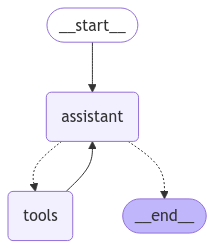

In [21]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant", tools_condition, # If the topic is very intricate, the model will research in arxiv or wiki
)

builder.add_edge("tools","assistant")

react_graph=builder.compile()

# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

## Using the Agent

In [22]:
messages = [HumanMessage(content="Is three js a good way to learn about Virtual reality?")]
messages = react_graph.invoke({"messages":messages})

In [23]:
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

Is three js a good way to learn about Virtual reality?
================================== Ai Message ==================================

### Exploring Virtual Reality: Is Three.js the Best Way to Learn?

Three.js has gained significant popularity among developers and designers alike for creating 3D graphics in the web browser. This JavaScript library is particularly praised for its powerful capabilities and ease of use, making it an attractive option for those looking to dive into the world of virtual reality (VR).

#### Why Three.js for Virtual Reality?

1. **Ease of Use**: Three.js is designed with simplicity in mind. Its intuitive API allows newcomers to quickly get up to speed and start creating 3D experiences without needing deep knowledge of WebGL or complex graphics programming.

2. **Rich Community and Resources**: The extensive community surrounding Three.js provides a wealth of tutorials, exampl